# Tracking thus far

In [179]:
import glob
import os
import enum
import re
import dask
import dask.array as da
import skimage
from skimage.io import imshow
import numpy as np
from tqdm.auto import tqdm
import napari

In [180]:
@enum.unique
class Channels(enum.Enum):
    BRIGHTFIELD = 0
    GFP = 1
    RFP = 2
    IRFP = 3
    MASK_2 = 97
    MASK_1 = 98
    MASK = 99

def parse_filename(filename: os.PathLike) -> dict:
    """Parse an OctopusHeavy filename and retreive metadata from the file.

    Parameters
    ----------
    filename : PathLike
        The full path to a file to parse.

    Returns
    -------
    metadata : dict
        A dictionary containing the parsed metadata.
    """
    
    OCTOPUSHEAVY_FILEPATTERN =(
        "r(?P<row>[0-9]+)c(?P<column>[0-9]+)f(?P<mosaic_pos>[0-9]+)p(?P<plane>[0-9]+)-ch(?P<channel>[0-9]+)"
        "sk(?P<time>[0-9]+)fk(?P<fk>[0-9]+)fl(?P<fl>[0-9]+)"
        )
    
    path, filename = os.path.split(filename)
    params = re.match(OCTOPUSHEAVY_FILEPATTERN, filename)

    filename_metadata = {
        "filename": filename,
        "channel": params.group("channel"),# Channels(int(params.group("channel"))),
        "time": params.group("time"),
        "row": params.group("row"), 
        "column": params.group("column"), 
        "mosaic_pos": params.group("mosaic_pos"), 
        "plane": params.group("plane"), 
        "fk": params.group("fk"), 
        "fl": params.group("fl")

    }

    return filename_metadata

#### Find images

In [3]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
fns = glob.glob(os.path.join(image_dir, '*.tiff'))
print(len(fns), 'image files found')

113400 image files found


In [4]:
print(fns[0], parse_filename(fns[0]))

/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c06f08p02-ch1sk36fk1fl1.tiff {'filename': 'r03c06f08p02-ch1sk36fk1fl1.tiff', 'channel': '1', 'time': '36', 'row': '03', 'column': '06', 'mosaic_pos': '08', 'plane': '02', 'fk': '1', 'fl': '1'}


#### Lazily load as dask array 

In [7]:
%%time
sample = skimage.io.imread(fns[0])
lazy_arrays = [dask.delayed(skimage.io.imread)(fn) for fn in fns]
lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
               for x in lazy_arrays]

CPU times: user 12.8 s, sys: 346 ms, total: 13.2 s
Wall time: 13 s


#### Organise said dask array based on filename metadata

In [16]:
### get dimensions
dimensions = dict()
for fn in fns:
    for prop in ['channel', 'time', 'row', 'column', 'mosaic_pos', 'plane']:
        dimensions.setdefault(prop, set())
        dimensions[prop].add(int(parse_filename(fn)[prop]))
dimensions

{'channel': {1, 2},
 'time': {1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75},
 'row': {3, 4, 5, 6},
 'column': {3, 4, 5, 6, 7, 8, 9, 10},
 'mosaic_pos': {1, 2, 3, 4, 5, 6, 7, 8, 9},
 'plane': {1, 2, 3}}

### Need to create an empty np.ndarray that can hold TCZYX, but maybe keep the channels seperate

So TZYX, but also tiled in the fov... so a 3x3 array, with each element being a 4d array of TZXY...

Need to take the FOV and turn it into a row and column

In [9]:
fns.sort(key=lambda f: int(parse_filename(f)["time"]))

In [10]:
fns

['/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c06f03p01-ch2sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r06c06f04p02-ch2sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c06f08p02-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c06f09p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c03f05p01-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r04c06f06p03-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c06f04p03-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r06c06f05p03-ch1sk1fk1fl1.tiff',
 '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c10f04p01-ch2sk1fk1fl1

## Important nomenclature note:

Row and column in the metadata is used to signify the row and column of the FOV position in the imaging dish. 
Row and column can also refer to the position of the image tile within the composite image mosaic. 

In [11]:
fov_scan_pattern = np.array(([2,3,4],
                             [7,6,5],
                             [8,1,9],))

In [95]:
os.path.basename(fns[0])

'r04c06f03p01-ch2sk1fk1fl1.tiff'

In [96]:
parse_filename('r04c06f03p01-ch2sk1fk1fl1.tiff')

{'filename': 'r04c06f03p01-ch2sk1fk1fl1.tiff',
 'channel': '2',
 'time': '1',
 'row': '04',
 'column': '06',
 'mosaic_pos': '03',
 'plane': '01',
 'fk': '1',
 'fl': '1'}

In [13]:
parse_filename(fns[0])

{'filename': 'r04c06f03p01-ch2sk1fk1fl1.tiff',
 'channel': '2',
 'time': '1',
 'row': '04',
 'column': '06',
 'mosaic_pos': '03',
 'plane': '01',
 'fk': '1',
 'fl': '1'}

In [74]:
image_nd_array = np.empty((len(dimensions['time']),
              len(dimensions['channel']),
              len(dimensions['plane']),
              3,
              3,
              ), 
              dtype = object)

In [75]:
image_nd_array.shape

(75, 2, 3, 3, 3)

In [76]:
for fn, frame in tqdm(zip(fns, lazy_arrays), total = len(lazy_arrays)): 
    filename_metadata = parse_filename(fn)
    mosaic_pos = int(filename_metadata['mosaic_pos'])
    mosaic_row_col = np.where(fov_scan_pattern == mosaic_pos)
    mosaic_row = mosaic_row_col[0][0]
    mosaic_column = mosaic_row_col[1][0]
    time = int(filename_metadata['time'])
    plane = int(filename_metadata['plane'])
    fov_row = int(filename_metadata['row'])
    fov_column = int(filename_metadata['column'])
    channel = int(filename_metadata['channel'])
    ### only looking at one fov_row, fov_column (i.e. one position on the plate)
    if fov_column == 3:
        if fov_row == 3:
            image_nd_array[time-1,  channel-1, plane-1, mosaic_row-1, mosaic_column-1,] = frame

  0%|          | 0/113400 [00:00<?, ?it/s]

### Now I have a numpy array of dask chunks, compile into a block

In [80]:
image = da.block(image_nd_array.tolist())

In [81]:
image

,Array,Chunk
Bytes,35.20 GiB,8.90 MiB
Shape,"(75, 2, 3, 6480, 6480)","(1, 1, 1, 2160, 2160)"
Count,32400 Tasks,4050 Chunks
Type,uint16,numpy.ndarray


In [82]:
image.shape

(75, 2, 3, 6480, 6480)

In [92]:
75*2*3*9

4050

### The channel axes are getting mixed up

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


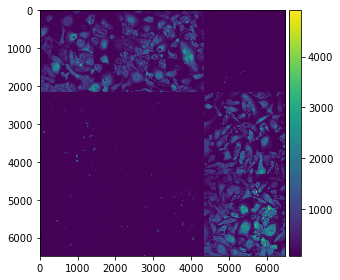

In [89]:
imshow(image[0,0,0,...].compute())

In [87]:
# load multichannel image in one line, with additional options
viewer = napari.view_image(
        image,
        channel_axis=1,
#         name=["membrane", "nuclei"],
#         colormap=["green", "magenta"],
#         contrast_limits=[[1000, 20000], [1000, 50000]],
#         )
)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [83]:
image[...,0,0,0].shape

(75, 2)

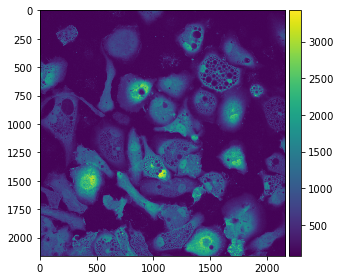

In [52]:
imshow(c[0,0,0,0,0].compute())

In [58]:
b

,Array,Chunk
Bytes,35.20 GiB,8.90 MiB
Shape,"(3, 3, 75, 6480, 4320)","(1, 1, 1, 2160, 2160)"
Count,32400 Tasks,4050 Chunks
Type,uint16,numpy.ndarray


## Define mosaic composition

In [33]:
### array that shows the location of each fov in the scan pattern
fov_scan_pattern = np.array(([2,3,4],
                             [7,6,5],
                             [8,1,9],))
fov_scan_pattern

array([[2, 3, 4],
       [7, 6, 5],
       [8, 1, 9]])

In [10]:
fns = glob.glob(os.path.join(image_dir, '*.tiff'))

In [30]:
import os, glob, re, enum

In [3]:
from skimage.io import imread, imshow

In [11]:
len(fns)

113400

In [12]:
fns[0]

'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/r03c06f08p02-ch1sk36fk1fl1.tiff'

In [13]:
fn = fns[0]

In [14]:
int(re.search('r(\d+)', fn).group(1))

3

### Dask array

In [47]:
import dask
import dask.array as da
import imageio
import numpy as np

In [34]:
sample = imageio.imread(fns[0])
sample.shape

(2160, 2160)

In [19]:
lazy_arrays = [dask.delayed(imageio.imread)(fn) for fn in fns]
lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
               for x in lazy_arrays]

In [21]:
len(lazy_arrays)

113400

In [35]:
lazy_arrays[0]

dask.array<from-value, shape=(2160, 2160), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

In [36]:
da.stack(lazy_arrays[:10], axis=0)

dask.array<stack, shape=(10, 2160, 2160), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

## da.block example

In [30]:
import enum
@enum.unique
class metadata(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    filename = 0
    channel = 1
    time = 2
    row = 3
    column = 4
    fov = 5
    plane = 6
    fk = 7
    fl = 8

In [31]:
fn_metadata = dict()
for fn in fns:
    for i, row_col in enumerate(extract_fn_metadata(fn)):
        fn_metadata.setdefault(metadata(i).name, set())
        fn_metadata[metadata(i).name].add(row_col)

NameError: name 'extract_fn_metadata' is not defined

In [44]:
fn_metadata

{'filename': {'row'},
 'channel': {'column'},
 'time': {'fov'},
 'row': {'plane'},
 'column': {'channel'},
 'fov': {'time'},
 'plane': {'fk'},
 'fk': {'fl'}}

Create an empty object array to organize each chunk that loads a TIFF

In [117]:
len(fn_metadata)

2

In [116]:
len(remap_comps)

2

In [137]:
a = np.empty(tuple(map(len, fn_metadata)), dtype=object)

In [142]:
tuple(map(len, fn_metadata))

(7, 4)

In [138]:
a.shape

(7, 4)

In [124]:
len(fns)

5400

In [128]:
len(lazy_arrays)

5400

In [140]:
for fn, x in zip(fns, lazy_arrays):
    column, row = extract_fn_metadata(fn)
    a[row, column] = x


IndexError: index 4 is out of bounds for axis 1 with size 4

In [16]:
fns[0]

'/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/inputs/instruments/L4OPERA/RELOCATED_2021/Claudio 2021/40e55fc4-6712-4d97-a921-61f0ee933038/r01c04-0757058077.tiff'

In [18]:
basenames = [os.path.basename(fn) for fn in fns]

In [20]:
basenames[0][1:3]

'01'

In [78]:
rows_cols = [extract_fn_metadata(fn) for fn in basenames]

In [80]:
rows_cols

[(1, 4),
 (6, 4),
 (2, 4),
 (6, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (6, 4),
 (3, 4),
 (3, 4),
 (5, 4),
 (6, 4),
 (5, 4),
 (6, 4),
 (4, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (3, 4),
 (4, 4),
 (5, 4),
 (4, 4),
 (4, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (2, 4),
 (6, 4),
 (6, 4),
 (4, 4),
 (4, 4),
 (5, 4),
 (1, 4),
 (1, 4),
 (4, 4),
 (2, 4),
 (2, 4),
 (1, 4),
 (1, 4),
 (3, 4),
 (1, 4),
 (4, 4),
 (1, 4),
 (3, 4),
 (2, 4),
 (4, 4),
 (2, 4),
 (2, 4),
 (1, 4),
 (6, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (1, 4),
 (2, 4),
 (6, 4),
 (4, 4),
 (3, 4),
 (6, 4),
 (5, 4),
 (1, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (1, 4),
 (4, 4),
 (3, 4),
 (2, 4),
 (4, 4),
 (6, 4),
 (3, 4),
 (4, 4),
 (2, 4),
 (1, 4),
 (5, 4),
 (5, 4),
 (6, 4),
 (3, 4),
 (4, 4),
 (1, 4),
 (5, 4),
 (2, 4),
 (4, 4),
 (5, 4),
 (6, 4),
 (4, 4),
 (1, 4),
 (2, 4),
 (5, 4),
 (3, 4),
 (5, 4),
 (3, 4),
 (6, 4),
 (5, 4),
 (2, 4),
 (4, 4),
 (1, 4),
 (5, 4),
 (3, 4),
 (1, 4),
 (3, 4),
 (6, 4),
 (1, 4),
 (1, 4),
 (3, 4),
 (2, 4),
 (5, 4),
 (3, 4),
 (3, 4),
 

In [29]:
min(rows), max(rows)

(1, 6)

In [32]:
min(cols), max(cols)

(4, 4)

In [23]:
import matplotlib.pyplot as plt

(array([900., 900., 900., 900., 900., 900.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <BarContainer object of 6 artists>)

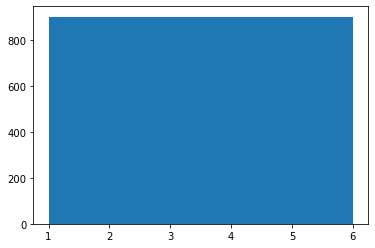

In [30]:
plt.hist(rows, bins = 6)

In [13]:
imread(fns[0])

array([[112, 104, 108, ..., 109, 113, 115],
       [118, 109, 110, ..., 104, 106, 112],
       [121, 112, 109, ..., 106, 101, 102],
       ...,
       [104, 106, 105, ..., 149, 156, 153],
       [109, 103, 101, ..., 152, 144, 144],
       [102, 100, 101, ..., 152, 145, 148]], dtype=uint16)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


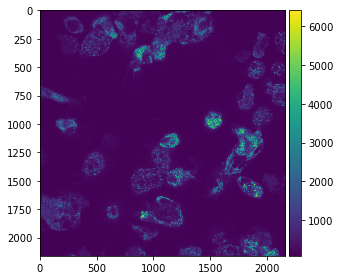

In [15]:
imshow(fns[0])

In [7]:
import sys

In [8]:
sys.path.append('../')
import data_utils

In [9]:
data_utils.size(fns[0])

'243.0 B'

In [21]:
os.stat(os.path.join(image_dir, fns[0]))

os.stat_result(st_mode=33216, st_ino=10, st_dev=54, st_nlink=1, st_uid=30046150, st_gid=30000513, st_size=6579061, st_atime=1661331511, st_mtime=1637774275, st_ctime=1637774275)

In [22]:
from skimage.io import imread, imshow

In [23]:
imread(fns[0])

PermissionError: [Errno 13] Permission denied: '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/inputs/instruments/L4OPERA/RELOCATED_2021/Claudio 2021/40e55fc4-6712-4d97-a921-61f0ee933038/r01c04-0757058077.tiff'